## Spatial distribution of retail outlets of a firm across regions of India

Objective: 

Analyse and visualize the spatial distribution of retail outlets covered by a retail firm across the regions of India.

Steps: 
1. Create a new environment to install geo-libraries
1. Import libraries
1. Load shapefile with regions
1. Load data with outlets
1. Distribution of outlets across regions
    1. Point-in-Polygon Analysis
    1. Nearest Neighbour Analysis
    

---

Data source download links for Census data: 
1. Collection: India Village-Level Geospatial Socio-Economic Data Set - University of Texas Libraries GeoData Search Results (utexas.edu) - https://geodata.lib.utexas.edu/?f%5Bdct_isPartOf_sm%5D%5B%5D=India+Village-Level+Geospatial+Socio-Economic+Data+Set
1. India Village-Level Geospatial Socio-Economic Data Set, v1: India Data Collection | SEDAC (columbia.edu) - https://sedac.ciesin.columbia.edu/data/set/india-india-village-level-geospatial-socio-econ-1991-2001  (Requires login)


Data dictionary for columns:

https://sedac.ciesin.columbia.edu/downloads/docs/india/india-india-village-level-geospatial-socio-econ-1991-2001-documentation.pdf


Mock data is used for firm data. Personally identifying information is removed.

---

### Create a new environment to install geo-libraries

geopandas
```
conda create geo -n python=3.8
conda activate geo
conda install geopandas
conda install mamba -c conda-forge
mamba install leafmap -c conda-forge
```

leafmap
```
pip install leafmap
```

### Import libraries 

In [1]:
# Geo-libraries
import geopandas as gpd
import rtree
import pyproj
import fiona
import shapely
import leafmap
import leafmap.foliumap as leafmap
import leafmap.leafmap as leafmap

In [125]:
# General libraries
import os
import time
import pyodbc
import pandas as pd
import numpy as np
from tqdm import tqdm 
from time import sleep

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Load shapefile with regions

In [3]:
# Read shapefile
p = gpd.read_file('Data/TN/india-village-census-2001-TN.shp')

<AxesSubplot:>

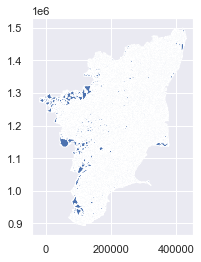

In [4]:
# Simple plot using matplotlib
p.plot()

In [5]:
# Convert to coordinate system 
p = p.to_crs(epsg=4326)

In [6]:
p.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17538 entries, 0 to 17537
Columns: 214 entries, SID to geometry
dtypes: float64(17), geometry(1), int64(176), object(20)
memory usage: 28.6+ MB


In [7]:
p.head()

SID DID   TID VILL_CODE          C_CODE01          NAME     UID  \
0  33  01  0002  00008800  3301000200008800     Karimanal  609637   
1  33  01  0001  00000300  3301000100000300    Arambakkam  609638   
2  33  01  0001  00000100  3301000100000100    Egumadurai  609639   
3  33  01  0001  00000200  3301000100000200   Naidukuppam  609640   
4  33  01  0001  00000500  3301000100000500  Kannambakkam  609641   

     CENSUS_COD  STATE  DISTRICT  ...  TANK_IRR  RIVER_IRR  LAKE_IRR  W_FALL  \
0  3.301000e+15     33         1  ...      0.00       0.00       0.0    0.00   
1  3.301000e+15     33         1  ...      0.00       0.00       0.0  117.52   
2  3.301000e+15     33         1  ...      0.05      30.84       0.0    0.00   
3  3.301000e+15     33         1  ...      0.05      18.88       0.0    0.00   
4  3.301000e+15     33         1  ...     99.54       0.00       0.0   90.41   

  OTH_IRR TOT_IRR   UN_IRR  CULT_WASTE  AREA_NA_CU  \
0     0.0    0.00  1325.00      240.00     2329.76   
1     0.0  909.52  1309.17      113.34      114.49   
2     0.0    0.00    31.23       91.20       65.07   
3     0.0    0.01    18.96       94.60       28.65   
4     0.0    0.00   189.95        7.09       79.61   

                                            geometry  
0  POLYGON ((80.26843 13.56393, 80.26915 13.56311...  
1  POLYGON ((80.03970 13.53863, 80.03973 13.53863...  
2  POLYGON ((80.02533 13.54443, 80.02442 13.54222...  
3  POLYGON ((80.02533 13.54443, 80.02968 13.53999...  
4  POLYGON ((80.02955 13.51974, 80.02998 13.51947...  

[5 rows x 214 columns]

In [8]:
p.columns

Index(['SID', 'DID', 'TID', 'VILL_CODE', 'C_CODE01', 'NAME', 'UID',
       'CENSUS_COD', 'STATE', 'DISTRICT',
       ...
       'TANK_IRR', 'RIVER_IRR', 'LAKE_IRR', 'W_FALL', 'OTH_IRR', 'TOT_IRR',
       'UN_IRR', 'CULT_WASTE', 'AREA_NA_CU', 'geometry'],
      dtype='object', length=214)

In [9]:
# Select columns from data dictionary(link attached) to get desired columns 
df_c = p[['UID', 'NAME', 'STATE', 'DISTRICT', 'SUB_DIST', 'VILL_CODE', 'TOWN_VILL', 'AREA' ,'LEVEL', 'NAME_1', 'TRU', 'geometry', 'No_HH', 'TOT_P', 'TOT_M', 'TOT_F','P_LIT',
'P_ILL']]

In [10]:
df_c.head()

UID          NAME  STATE  DISTRICT  SUB_DIST VILL_CODE  TOWN_VILL  \
0  609637     Karimanal     33         1         2  00008800       8800   
1  609638    Arambakkam     33         1         1  00000300        300   
2  609639    Egumadurai     33         1         1  00000100        100   
3  609640   Naidukuppam     33         1         1  00000200        200   
4  609641  Kannambakkam     33         1         1  00000500        500   

      AREA    LEVEL           NAME_1    TRU  \
0  3894.76     None  KARIMANAL  (UI)   None   
1  1767.77  VILLAGE       Arambakkam  Rural   
2   533.05  VILLAGE       Egumadurai  Rural   
3   452.78  VILLAGE      Naidukuppam  Rural   
4   342.19  VILLAGE     Kannambakkam  Rural   

                                            geometry  No_HH  TOT_P  TOT_M  \
0  POLYGON ((80.26843 13.56393, 80.26915 13.56311...      0      0      0   
1  POLYGON ((80.03970 13.53863, 80.03973 13.53863...   1810   8475   4183   
2  POLYGON ((80.02533 13.54443, 80.02442 13.54222...    275   1087    544   
3  POLYGON ((80.02533 13.54443, 80.02968 13.53999...     67    320    159   
4  POLYGON ((80.02955 13.51974, 80.02998 13.51947...    264   1018    509   

   TOT_F  P_LIT  P_ILL  
0      0      0      0  
1   4292   4107   4368  
2    543    530    557  
3    161    186    134  
4    509    570    448

In [11]:
# State codes
df_c['STATE'].value_counts()

33    17533
0         5
Name: STATE, dtype: int64

In [12]:
# Population buckets 10, 5L-10L, 2L-5L, 1L-2L, 50k-1L, 25k-50k , 10k-25k, 5k-10k, <5k

conditions = [df_c['TOT_P'] > 1000000,
              (df_c['TOT_P'] <= 1000000) & (df_c['TOT_P'] > 500000),
              (df_c['TOT_P'] <= 500000) & (df_c['TOT_P'] > 200000),
              (df_c['TOT_P'] <= 200000) & (df_c['TOT_P'] > 100000),
              (df_c['TOT_P'] <= 100000) & (df_c['TOT_P'] > 50000),
              (df_c['TOT_P'] <= 50000) & (df_c['TOT_P'] > 25000),
              (df_c['TOT_P'] <= 25000) & (df_c['TOT_P'] > 10000),
              (df_c['TOT_P'] <= 10000) & (df_c['TOT_P'] > 5000),
              df_c['TOT_P'] <= 5000
             ]

choices = ['>10L','5L-10L','2L-5L','1L-2L','50k-1L','25k-50k','10k-25k','5k-10k','<5k']
 
df_c['Population'] = np.select(conditions, choices, default= df_c['TOT_P'] )

In [13]:
# Plot geodataframe as map
m = leafmap.Map(center=[0, 0], zoom=2)

m.add_gdf(df_c, layer_name="Map")

In [14]:
#m

> Sample image output
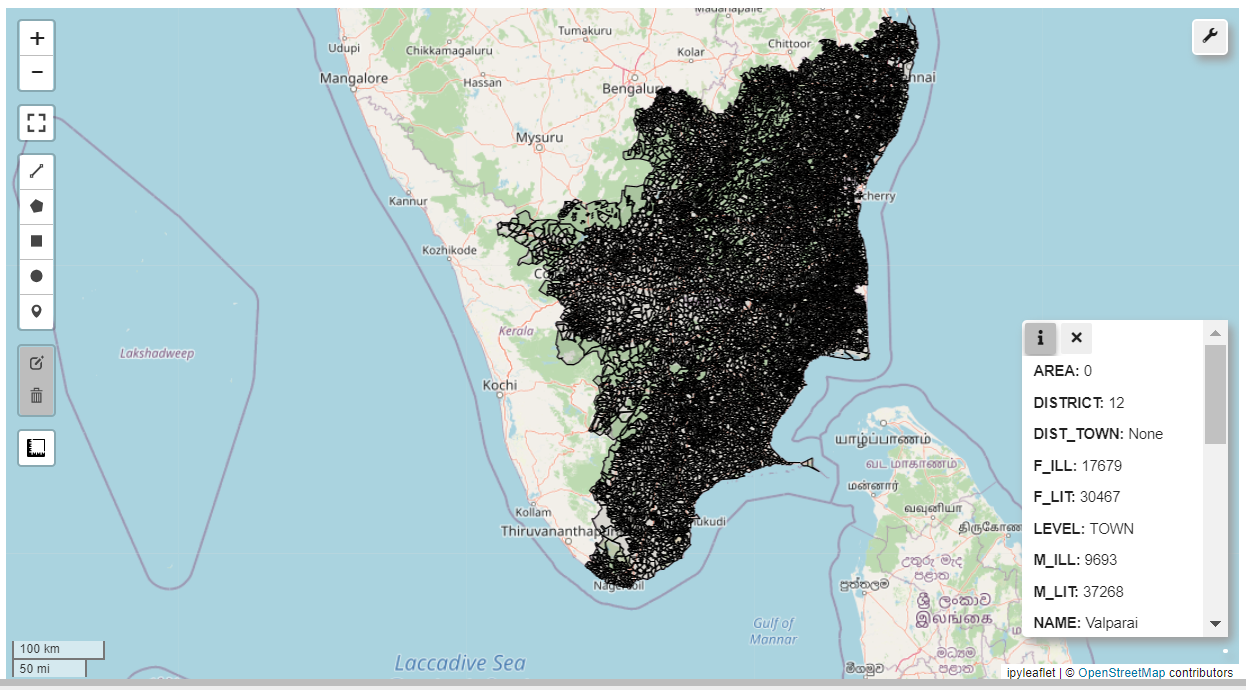

### Load data with outlets

In [27]:
# Mock data is used for firm data. Personally identifying information is changed & removed.

%time df_o = pd.read_csv('outlets.csv')

CPU times: total: 3.89 s
Wall time: 1min 23s


In [155]:
df_o.head()

Outlet_code            Outlet_Name                    Group_Name  \
0  6001007763     Chithamani medical                FMCG - Medical   
1  6411432840  SRI THIRUPPATHI STORE      PC-KIRANA/GENERAL STORES   
2  6211230725          NIVETHA STORE  FMCG - Kirana/General Stores   
3  6251085171        KAMATCHI AGENCY  FMCG - Kirana/General Stores   
4  6001009747      SNOWS ENTERPRISES  FMCG - Kirana/General Stores   

           City       State    Latitude   Longitude  
0       CHENNAI  TAMIL NADU   12.994045  80.2012408  
1  METTUPALAYAM  TAMIL NADU  11.2391243  76.9648461  
2      THOTIYAM  TAMIL NADU   11.025973  78.3859353  
3       MADURAI  TAMIL NADU   9.9069297  78.1184912  
4       CHENNAI  TAMIL NADU  13.0415954  80.0965012

In [158]:
# Number of retail outlets
len(df_o['Outlet_code']) 

140882

In [159]:
# Remove null values
nulllist = ['NULL','']
df_o = df_o[~df_o.Latitude.isin(nulllist)]

In [160]:
# Number of retail outlets after removing null
len(df_o['Outlet_code'])

140769

In [161]:
# Remove duplicates
df_o = df_o.drop_duplicates()

In [162]:
len(df_o['Outlet_code'])

103167

In [163]:
df_ck = gpd.GeoDataFrame(df_o, geometry=gpd.points_from_xy(df_o.Longitude, df_o.Latitude), crs=4326)
df_ck = df_ck.reset_index(drop=True)

### Distribution of outlets across regions

#### Point-in-Polygon Analysis

In [164]:
points = df_ck
polygons = df_c

In [165]:
# Spatial Joins
%time pointsInPolygon = gpd.sjoin(points, polygons, how="inner", op='intersects')

CPU times: total: 20.2 s
Wall time: 20.7 s


In [166]:
pointsInPolygon.head()

Outlet_code         Outlet_Name                    Group_Name     City  \
0    6001007763  Chithamani medical                FMCG - Medical  CHENNAI   
31   6003477757         Hari store   FMCG - Kirana/General Stores  CHENNAI   
60   6001007411     Sri raama dairy  FMCG - Kirana/General Stores  CHENNAI   
115  6001005899  THIRUMURUGAN STORE  FMCG - Kirana/General Stores  CHENNAI   
117  6001002588   Kalaiselvan store  FMCG - Kirana/General Stores  CHENNAI   

          State    Latitude   Longitude                   geometry  \
0    TAMIL NADU   12.994045  80.2012408  POINT (80.20124 12.99404)   
31   TAMIL NADU  12.9997094  80.2028321  POINT (80.20283 12.99971)   
60   TAMIL NADU  12.9940253  80.2013181  POINT (80.20132 12.99403)   
115  TAMIL NADU  12.9985107  80.2055436  POINT (80.20554 12.99851)   
117  TAMIL NADU  12.9943198  80.2023259  POINT (80.20233 12.99432)   

     index_right     UID  ... LEVEL          NAME_1    TRU  No_HH  TOT_P  \
0            843  610480  ...  TOWN  Ramapuram (CT)  Urban   6458  27895   
31           843  610480  ...  TOWN  Ramapuram (CT)  Urban   6458  27895   
60           843  610480  ...  TOWN  Ramapuram (CT)  Urban   6458  27895   
115          843  610480  ...  TOWN  Ramapuram (CT)  Urban   6458  27895   
117          843  610480  ...  TOWN  Ramapuram (CT)  Urban   6458  27895   

     TOT_M  TOT_F  P_LIT P_ILL Population  
0    14319  13576  20783  7112    25k-50k  
31   14319  13576  20783  7112    25k-50k  
60   14319  13576  20783  7112    25k-50k  
115  14319  13576  20783  7112    25k-50k  
117  14319  13576  20783  7112    25k-50k  

[5 rows x 27 columns]

In [167]:
# Add a field with 1 as a constant value
pointsInPolygon['countofoutlets']=1

In [168]:
# Group according to the columns by which you want to aggregate data
pointsInPolygon.groupby(['UID','NAME','LEVEL','Population','TOT_P','State'])['countofoutlets'].size().reset_index(name="countofoutlets").sort_values(by='countofoutlets')

UID               NAME    LEVEL Population    TOT_P       State  \
0     609638         Arambakkam  VILLAGE     5k-10k     8475  TAMIL NADU   
2360  619140      Kottamangalam  VILLAGE        <5k     1735  TAMIL NADU   
1414  616225           Samballi  VILLAGE        <5k     1823  TAMIL NADU   
2818  620506        Tirupugalur  VILLAGE        <5k     3171  TAMIL NADU   
1411  616221     Pallagachcheri  VILLAGE        <5k     3296  TAMIL NADU   
...      ...                ...      ...        ...      ...         ...   
2580  619812  Coimbatore (Part)     TOWN     5L-10L   930882  TAMIL NADU   
1538  616634              Salem     TOWN     5L-10L   696760  TAMIL NADU   
2884  620725    Tiruchirappalli     TOWN     5L-10L   752066  TAMIL NADU   
3603  624179            Madurai     TOWN     5L-10L   928869  TAMIL NADU   
136   610187            Chennai     TOWN       >10L  4343645  TAMIL NADU   

      countofoutlets  
0                  1  
2360               1  
1414               1  
2818               1  
1411               1  
...              ...  
2580            1731  
1538            1924  
2884            2473  
3603            2827  
136             7379  

[4212 rows x 7 columns]

In [23]:
# Different variant of group by with aggregations
#pointsInPolygon.groupby(['UID']).agg({ 'NAME':'first','LEVEL':'first', 'Population':'first','TOT_P':'first', 'countofoutlets':'sum'}).reset_index().sort_values(by='countofoutlets')

In [169]:
# Count of outlets in each region
pointsInPolygon.groupby('UID').count().geometry.rename('countofoutlets').reset_index()

UID  countofoutlets
0     609638               1
1     609644              14
2     609653               1
3     609662              39
4     609668              67
...      ...             ...
4275  627161               7
4276  627162               8
4277  627166               1
4278  627167               7
4279  627173               8

[4280 rows x 2 columns]

In [170]:
pip = pointsInPolygon.groupby('UID').count().geometry.rename('countofoutlets').reset_index()

In [171]:
# Join count of outlets in regions data
pip1 = polygons.merge(pip,how="left",on="UID")

In [172]:
pip1.head(5)

UID          NAME  STATE  DISTRICT  SUB_DIST VILL_CODE  TOWN_VILL  \
0  609637     Karimanal     33         1         2  00008800       8800   
1  609638    Arambakkam     33         1         1  00000300        300   
2  609639    Egumadurai     33         1         1  00000100        100   
3  609640   Naidukuppam     33         1         1  00000200        200   
4  609641  Kannambakkam     33         1         1  00000500        500   

      AREA    LEVEL           NAME_1    TRU  \
0  3894.76     None  KARIMANAL  (UI)   None   
1  1767.77  VILLAGE       Arambakkam  Rural   
2   533.05  VILLAGE       Egumadurai  Rural   
3   452.78  VILLAGE      Naidukuppam  Rural   
4   342.19  VILLAGE     Kannambakkam  Rural   

                                            geometry  No_HH  TOT_P  TOT_M  \
0  POLYGON ((80.26843 13.56393, 80.26915 13.56311...      0      0      0   
1  POLYGON ((80.03970 13.53863, 80.03973 13.53863...   1810   8475   4183   
2  POLYGON ((80.02533 13.54443, 80.02442 13.54222...    275   1087    544   
3  POLYGON ((80.02533 13.54443, 80.02968 13.53999...     67    320    159   
4  POLYGON ((80.02955 13.51974, 80.02998 13.51947...    264   1018    509   

   TOT_F  P_LIT  P_ILL Population  countofoutlets  
0      0      0      0        <5k             NaN  
1   4292   4107   4368     5k-10k             1.0  
2    543    530    557        <5k             NaN  
3    161    186    134        <5k             NaN  
4    509    570    448        <5k             NaN

In [173]:
# Replace null with 0
pip1['countofoutlets'] = pip1['countofoutlets'].fillna(0)

In [174]:
sum(pip1['countofoutlets'].isna())

0

In [176]:
# Column for outlet presence
pip1['outlet_presence'] = ['Yes' if x>0 else 'No' for x in pip1['countofoutlets']]

In [178]:
# Save results to excel - outlet data with regions
pointsInPolygon.to_excel("results_1.xlsx",index=False)

# Save results to excel - region data with outlet count
pip1.to_excel("results_2.xlsx",index=False)

> Further Analysis

In [179]:
# Bins
bins = [0, 0.01, 1, 5, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 500, 800, 1000, 5000, 10000, 20000]
pip1['countofoutlets'].value_counts(bins=bins, sort=False).reset_index(name='Number of Regions').rename(columns={'index':'Range of outlets'})

Range of outlets  Number of Regions
0       (-0.001, 0.01]              13258
1          (0.01, 1.0]                820
2           (1.0, 5.0]               1368
3          (5.0, 10.0]                683
4         (10.0, 20.0]                577
5         (20.0, 30.0]                240
6         (30.0, 40.0]                135
7         (40.0, 50.0]                 80
8         (50.0, 60.0]                 63
9         (60.0, 80.0]                 83
10       (80.0, 100.0]                 59
11      (100.0, 200.0]                100
12      (200.0, 300.0]                 35
13      (300.0, 500.0]                 20
14      (500.0, 800.0]                  8
15     (800.0, 1000.0]                  1
16    (1000.0, 5000.0]                  7
17   (5000.0, 10000.0]                  1
18  (10000.0, 20000.0]                  0

In [180]:
pip1.groupby(pd.cut(pip1['countofoutlets'], bins)).size()

countofoutlets
(0.0, 0.01]              0
(0.01, 1.0]            820
(1.0, 5.0]            1368
(5.0, 10.0]            683
(10.0, 20.0]           577
(20.0, 30.0]           240
(30.0, 40.0]           135
(40.0, 50.0]            80
(50.0, 60.0]            63
(60.0, 80.0]            83
(80.0, 100.0]           59
(100.0, 200.0]         100
(200.0, 300.0]          35
(300.0, 500.0]          20
(500.0, 800.0]           8
(800.0, 1000.0]          1
(1000.0, 5000.0]         7
(5000.0, 10000.0]        1
(10000.0, 20000.0]       0
dtype: int64

In [181]:
pip1.drop_duplicates()['countofoutlets'].max()

7379.0

In [182]:
# Total regions
len(pip1['UID'].unique())

17538

In [183]:
# Regions covered by outlets
len(pip['UID'].unique())

4280

In [276]:
# Number of outlets and regions in population bins
m=pip1.groupby(['Population','outlet_presence']).agg(outlet_count=('countofoutlets', np.sum),region_count=('countofoutlets', 'count')).unstack(fill_value=0)

m.loc['Grand Total'] = m.sum()
m['total_region'] = m[('region_count', 'Yes')]+m[('region_count', 'No')]
m['region_coverage%'] = round(m[('region_count', 'Yes')]/(m[('region_count', 'Yes')]+m[('region_count', 'No')])* 100)
m['outlet/region'] = round(m[('outlet_count', 'Yes')]/m['total_region'])

m

outlet_count           region_count         total_region  \
outlet_presence           No       Yes           No     Yes                
Population                                                                 
10k-25k                  0.0   17946.0        138.0   460.0        598.0   
1L-2L                    0.0    3717.0          2.0    13.0         15.0   
25k-50k                  0.0   10632.0         10.0   107.0        117.0   
2L-5L                    0.0    6383.0          0.0     9.0          9.0   
50k-1L                   0.0    8606.0          3.0    53.0         56.0   
5L-10L                   0.0   10589.0          0.0    10.0         10.0   
5k-10k                   0.0   15598.0        652.0   876.0       1528.0   
<5k                      0.0   22213.0      12453.0  2751.0      15204.0   
>10L                     0.0    7379.0          0.0     1.0          1.0   
Grand Total              0.0  103063.0      13258.0  4280.0      17538.0   

                region_coverage% outlet/region  
outlet_presence                                 
Population                                      
10k-25k                     77.0          30.0  
1L-2L                       87.0         248.0  
25k-50k                     91.0          91.0  
2L-5L                      100.0         709.0  
50k-1L                      95.0         154.0  
5L-10L                     100.0        1059.0  
5k-10k                      57.0          10.0  
<5k                         18.0           1.0  
>10L                       100.0        7379.0  
Grand Total                 24.0           6.0

> **Visulization in Map**

**Distribution of outlets in regions in state**

<AxesSubplot:title={'center':'Distribution of firm outlets in TN'}>

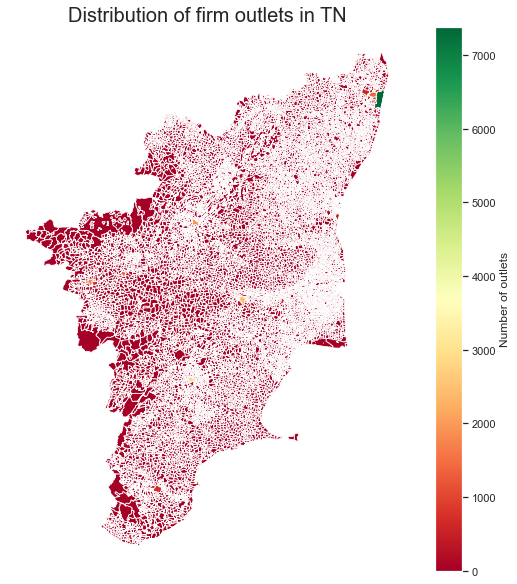

In [202]:
# Plot for state Tamil Nadu
#Create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Distribution of firm outlets in TN', fontdict={'fontsize': '20', 'fontweight' : '10'})
# Plot the figure
pip1.plot(column='countofoutlets',label = 'countofoutlets', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='1',legend=True,markersize=[39.739192, -104.990337], legend_kwds={'label': "Number of outlets"})

**Distribution of outlets in regions in district**

<AxesSubplot:title={'center':'Distribution of firm outlets in a district'}>

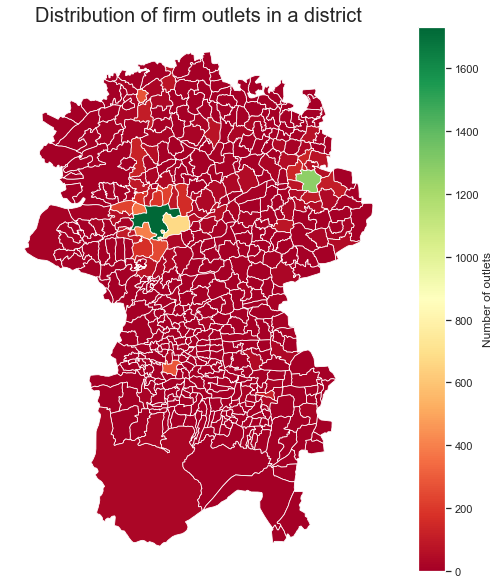

In [203]:
# Plot for district Coimbatore
#Create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Distribution of firm outlets in a district', fontdict={'fontsize': '20', 'fontweight' : '10'})
# Plot the figure
pip1[pip1['DISTRICT']==12].plot(column='countofoutlets',label = 'countofoutlets', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='1',legend=True, legend_kwds={'label': "Number of outlets"})

<AxesSubplot:title={'center':'Distribution of firm outlets in a district'}>

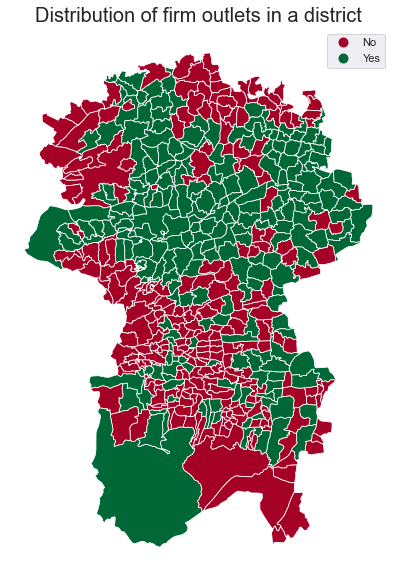

In [212]:
# Plot for district Coimbatore
#Create figure and axes for Matplotlib and set the title
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.axis('off')
ax.set_title('Distribution of firm outlets in a district', fontdict={'fontsize': '20', 'fontweight' : '10'})
# Plot the figure
pip1[pip1['DISTRICT']==12].plot(column='outlet_presence',label = 'outlet_presence', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='1',legend=True)

**Heatmap of outlets in a district**

In [213]:
# Plot geodataframe as map
m = leafmap.Map(center=[0, 0], zoom=2)
m.add_heatmap(pointsInPolygon,latitude="Latitude",longitude='Longitude',value="countofoutlets",name="Heat map",radius=20,)

In [83]:
#m

> 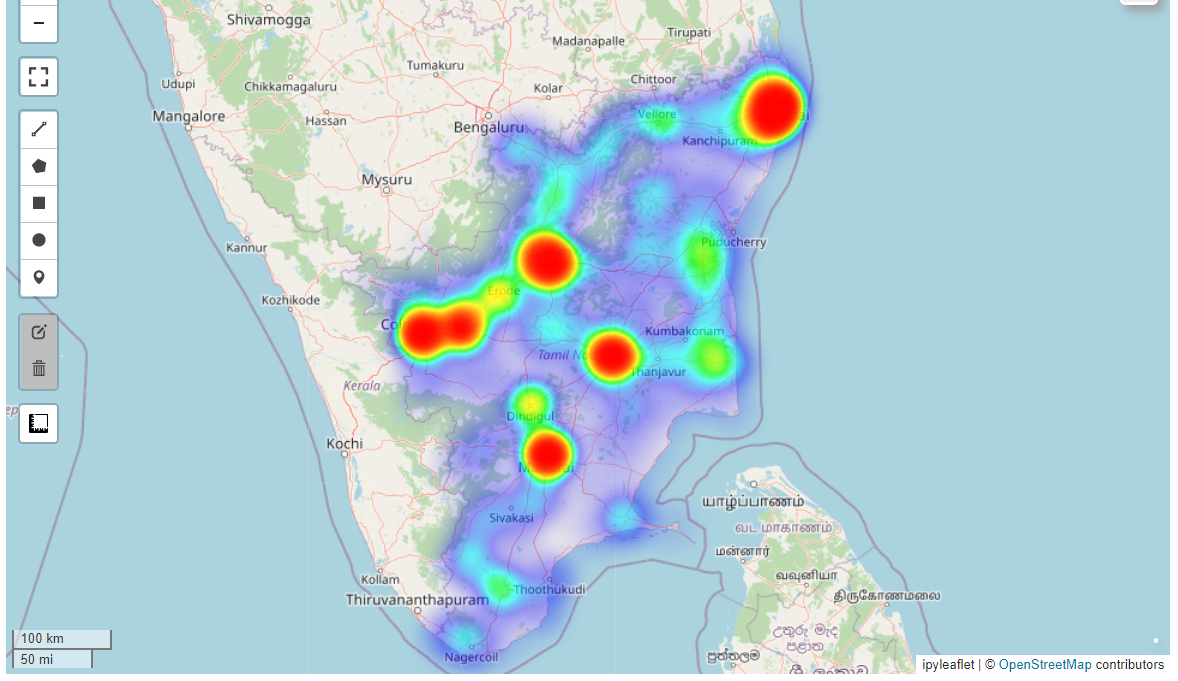

**Distribution of outlets in regions in district**

In [98]:
q = leafmap.Map(center=[0, 0], zoom=2)

# Add villages boundaries from census as 1st layer
df_c1 = df_c[df_c['DISTRICT']==12].reset_index(drop=True)
q.add_gdf(df_c1, layer_name="Regions")

# Add villages as 2nd layer
pointsInPolygon1 = pointsInPolygon[pointsInPolygon['DISTRICT']==12].reset_index(drop=True).head(5000)  # Plot head due to huge size
q.add_points_from_xy(pointsInPolygon1, x="Longitude", y="Latitude",layer_name="Outlets")

In [105]:
#q

> 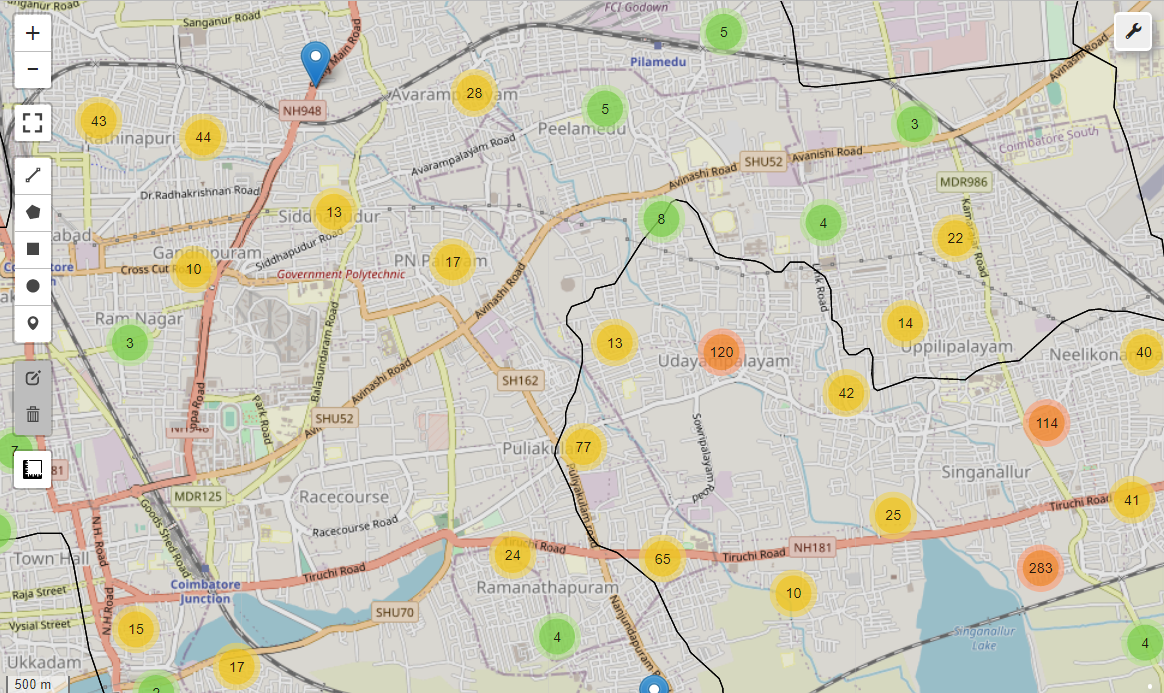 

#### Nearest Neighbour Analysis

This method is time consuming & computationally intensive compared to Point-in-Polygon analysis. Used only when distance is to be accounted in the scope. 

**Method 1** - Using polygon distance

In [214]:
# Test for sample data
point = df_ck.head(100).geometry
polygon = df_c.head(100).geometry

In [109]:
# Use full data
point = df_ck.geometry
polygon = df_c.geometry

If dataframe is smaller, skip slicing dataframe & run below

In [215]:
%time out = point.apply(lambda p: polygon.distance(p))

CPU times: total: 4.28 s
Wall time: 4.29 s


In [216]:
out

0         1         2         3         4         5         6   \
0   0.432291  0.529853  0.550442  0.551708  0.520075  0.515475  0.467174   
1   3.965630  3.830255  3.801199  3.819342  3.801521  3.819510  3.853031   
2   3.058803  2.995432  2.976647  2.986689  2.963848  2.973681  2.988181   
3   4.129211  4.095286  4.079729  4.087087  4.063579  4.070842  4.078300   
4   0.423741  0.468136  0.479022  0.482486  0.452356  0.448832  0.417309   
..       ...       ...       ...       ...       ...       ...       ...   
95  3.048511  3.019599  3.004798  3.011582  2.987916  2.994398  3.000119   
96  5.283966  5.280759  5.267409  5.273892  5.249920  5.254080  5.254138   
97  0.319881  0.457592  0.488189  0.486639  0.455014  0.444097  0.385717   
98  1.797522  1.643320  1.611937  1.631699  1.616167  1.636167  1.675780   
99  3.315396  3.238358  3.217580  3.229296  3.207001  3.218364  3.236475   

          7         8         9   ...        90        91        92        93  \
0   0.485324  0.499038  0.502730  ...  0.387886  0.393832  0.407398  0.387310   
1   3.889600  3.870962  3.771165  ...  3.971580  3.834616  3.677545  3.879237   
2   3.019641  3.009062  2.934006  ...  3.034075  2.940932  2.816004  2.972376   
3   4.108323  4.100564  4.033308  ...  4.098158  4.023712  3.912215  4.049728   
4   0.439461  0.446107  0.433149  ...  0.391969  0.345531  0.320996  0.354942   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  3.029812  3.022648  2.957569  ...  3.017254  2.944298  2.835804  2.969612   
96  5.282249  5.277465  5.219522  ...  5.247011  5.192578  5.096514  5.212675   
97  0.399037  0.418795  0.440713  ...  0.270028  0.314543  0.371602  0.294103   
98  1.713196  1.692123  1.584994  ...  1.823932  1.669951  1.505122  1.720107   
99  3.268942  3.256862  3.177571  ...  3.294911  3.193683  3.062045  3.227628   

          94        95        96        97        98        99  
0   0.389555  0.391099  0.361239  0.376077  0.399767  0.385622  
1   3.956008  3.856052  3.865542  3.915137  3.829877  3.814196  
2   3.027766  2.958424  2.954150  2.993203  2.939598  2.923770  
3   4.094992  4.039044  4.030346  4.064450  4.023569  4.008095  
4   0.388491  0.352087  0.332824  0.360177  0.349455  0.333598  
..       ...       ...       ...       ...       ...       ...  
95  3.014166  2.959317  2.950129  2.983825  2.944336  2.928937  
96  5.246759  5.205482  5.192322  5.220996  5.193667  5.178138  
97  0.273003  0.303630  0.265785  0.270845  0.321906  0.311024  
98  1.804034  1.693203  1.709338  1.760654  1.664525  1.649184  
99  3.287311  3.212016  3.210032  3.251157  3.191752  3.175821  

[100 rows x 100 columns]

In [217]:
out.idxmin(axis="columns")

0     96
1     92
2     92
3     92
4     92
      ..
95    92
96    92
97    96
98    75
99    92
Length: 100, dtype: int64

In [218]:
df_c.iloc[out.idxmin(axis="columns")][["UID","NAME","NAME_1", "No_HH", "TOT_P", "TOT_M", "TOT_F","geometry"]].reset_index(drop=True)

UID           NAME         NAME_1  No_HH  TOT_P  TOT_M  TOT_F  \
0   609733          Medur          Medur    818   3217   1588   1629   
1   609729        Thervoy        Thervoy    582   2667   1332   1335   
2   609729        Thervoy        Thervoy    582   2667   1332   1335   
3   609729        Thervoy        Thervoy    582   2667   1332   1335   
4   609729        Thervoy        Thervoy    582   2667   1332   1335   
..     ...            ...            ...    ...    ...    ...    ...   
95  609729        Thervoy        Thervoy    582   2667   1332   1335   
96  609729        Thervoy        Thervoy    582   2667   1332   1335   
97  609733          Medur          Medur    818   3217   1588   1629   
98  609712  Varnasikuppam  Varnasikuppam    216    959    487    472   
99  609729        Thervoy        Thervoy    582   2667   1332   1335   

                                             geometry  
0   POLYGON ((80.23780 13.39215, 80.23797 13.39192...  
1   POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
2   POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
3   POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
4   POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
..                                                ...  
95  POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
96  POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
97  POLYGON ((80.23780 13.39215, 80.23797 13.39192...  
98  POLYGON ((79.93938 13.41060, 79.94657 13.41093...  
99  POLYGON ((80.02232 13.39385, 80.02204 13.39312...  

[100 rows x 8 columns]

In [219]:
df11 = df_o.reset_index(drop=True)
df22 = df_c.iloc[out.idxmin(axis="columns")][["UID","NAME","NAME_1", "No_HH", "TOT_P", "TOT_M", "TOT_F","geometry"]].reset_index(drop=True)

df33 = pd.concat([df11, df22], axis=1)

In [220]:
df33.head()

Outlet_code            Outlet_Name                    Group_Name  \
0  6001007763     Chithamani medical                FMCG - Medical   
1  6411432840  SRI THIRUPPATHI STORE      PC-KIRANA/GENERAL STORES   
2  6211230725          NIVETHA STORE  FMCG - Kirana/General Stores   
3  6251085171        KAMATCHI AGENCY  FMCG - Kirana/General Stores   
4  6001009747      SNOWS ENTERPRISES  FMCG - Kirana/General Stores   

           City       State    Latitude   Longitude  \
0       CHENNAI  TAMIL NADU   12.994045  80.2012408   
1  METTUPALAYAM  TAMIL NADU  11.2391243  76.9648461   
2      THOTIYAM  TAMIL NADU   11.025973  78.3859353   
3       MADURAI  TAMIL NADU   9.9069297  78.1184912   
4       CHENNAI  TAMIL NADU  13.0415954  80.0965012   

                    geometry       UID     NAME   NAME_1  No_HH   TOT_P  \
0  POINT (80.20124 12.99404)  609733.0    Medur    Medur  818.0  3217.0   
1  POINT (76.96485 11.23912)  609729.0  Thervoy  Thervoy  582.0  2667.0   
2  POINT (78.38594 11.02597)  609729.0  Thervoy  Thervoy  582.0  2667.0   
3   POINT (78.11849 9.90693)  609729.0  Thervoy  Thervoy  582.0  2667.0   
4  POINT (80.09650 13.04160)  609729.0  Thervoy  Thervoy  582.0  2667.0   

    TOT_M   TOT_F                                           geometry  
0  1588.0  1629.0  POLYGON ((80.23780 13.39215, 80.23797 13.39192...  
1  1332.0  1335.0  POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
2  1332.0  1335.0  POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
3  1332.0  1335.0  POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
4  1332.0  1335.0  POLYGON ((80.02232 13.39385, 80.02204 13.39312...

If dataframe is bigger, use below steps

Slice a large pandas dataframe into chunks - https://stackoverflow.com/questions/44729727/pandas-slice-large-dataframe-into-chunks

In [221]:
# Test for sample data
point = df_ck.head(100).geometry
polygon = df_c.head(100).geometry

In [ ]:
# Use full data
point = df_ck.geometry
polygon = df_c.geometry

In [222]:
# Split dataframe into chunks
n = 5000  #chunk row size
list_df = [point[i:i+n] for i in range(0,len(point),n)]

In [223]:
out = [(sleep(2),i.apply(lambda p: polygon.distance(p))) for i in tqdm(list_df)]

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


In [224]:
# Concat the chunks of dataframe
df_merged = pd.DataFrame()
df1_merged = [df_merged.append(i) for i in out]
df2_merged = pd.concat(df1_merged, axis=0)

df2_merged.idxmin(axis="columns")

0     96
1     92
2     92
3     92
4     92
      ..
95    92
96    92
97    96
98    75
99    92
Length: 100, dtype: int64

In [225]:
# Combine dataframes
df11 = df_o.reset_index(drop=True)
df22 = df_c.iloc[df2_merged.idxmin(axis="columns")][["UID","NAME","NAME_1","LEVEL", "No_HH", "TOT_P", "TOT_M", "TOT_F","geometry"]].reset_index(drop=True)

df33 = pd.concat([df11, df22], axis=1)

In [226]:
df33.head()

Outlet_code            Outlet_Name                    Group_Name  \
0  6001007763     Chithamani medical                FMCG - Medical   
1  6411432840  SRI THIRUPPATHI STORE      PC-KIRANA/GENERAL STORES   
2  6211230725          NIVETHA STORE  FMCG - Kirana/General Stores   
3  6251085171        KAMATCHI AGENCY  FMCG - Kirana/General Stores   
4  6001009747      SNOWS ENTERPRISES  FMCG - Kirana/General Stores   

           City       State    Latitude   Longitude  \
0       CHENNAI  TAMIL NADU   12.994045  80.2012408   
1  METTUPALAYAM  TAMIL NADU  11.2391243  76.9648461   
2      THOTIYAM  TAMIL NADU   11.025973  78.3859353   
3       MADURAI  TAMIL NADU   9.9069297  78.1184912   
4       CHENNAI  TAMIL NADU  13.0415954  80.0965012   

                    geometry       UID     NAME   NAME_1    LEVEL  No_HH  \
0  POINT (80.20124 12.99404)  609733.0    Medur    Medur  VILLAGE  818.0   
1  POINT (76.96485 11.23912)  609729.0  Thervoy  Thervoy  VILLAGE  582.0   
2  POINT (78.38594 11.02597)  609729.0  Thervoy  Thervoy  VILLAGE  582.0   
3   POINT (78.11849 9.90693)  609729.0  Thervoy  Thervoy  VILLAGE  582.0   
4  POINT (80.09650 13.04160)  609729.0  Thervoy  Thervoy  VILLAGE  582.0   

    TOT_P   TOT_M   TOT_F                                           geometry  
0  3217.0  1588.0  1629.0  POLYGON ((80.23780 13.39215, 80.23797 13.39192...  
1  2667.0  1332.0  1335.0  POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
2  2667.0  1332.0  1335.0  POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
3  2667.0  1332.0  1335.0  POLYGON ((80.02232 13.39385, 80.02204 13.39312...  
4  2667.0  1332.0  1335.0  POLYGON ((80.02232 13.39385, 80.02204 13.39312...

**Method 2** - Nearest points & Centroids

In [227]:
from shapely.ops import unary_union
from shapely.ops import nearest_points

# Test for sample data
a = df_ck.head(100)
b = df_c.head(100)

# Use full data
#a = df_ck
#b = df_c

# Extract point from you GeoDataFrame
point = a.geometry

# Compute centroid of your area
centroidd = b.centroid

# Create unary union from centroid of area
centroids = unary_union(centroidd)

%time out = point.apply(lambda p: centroidd == nearest_points(p, centroids)[1])

#out.idxmax(axis="columns")

point.apply(lambda p: b.centroid == nearest_points(p, b.centroid.unary_union)[1]).idxmax(axis="columns")

CPU times: total: 531 ms
Wall time: 532 ms


0     96
1     75
2     92
3     92
4     89
      ..
95    92
96    92
97    97
98    75
99    75
Length: 100, dtype: int64